# 데이터 불러오기

In [1]:
import pandas as pd
import numpy as np
import math
import seaborn as sns
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeRegressor

In [2]:
# 한글 폰트 설정하기
fe = fm.FontEntry(fname = 'MaruBuri-Regular.otf', name = 'MaruBuri')
fm.fontManager.ttflist.insert(0, fe)
plt.rc('font', family='MaruBuri')

In [186]:
# train, test 데이터를 불러옵니다.
train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')

In [4]:
train.head()

,ID,제조사,모델,차량상태,배터리용량,구동방식,주행거리(km),보증기간(년),사고이력,연식(년),가격(백만원)
0,TRAIN_0000,P사,TayGTS,Nearly New,86.077,AWD,13642,0,No,2,159.66
1,TRAIN_0001,K사,Niro,Nearly New,56.000,FWD,10199,6,No,0,28.01
2,TRAIN_0002,A사,eT,Brand New,91.200,AWD,2361,7,No,0,66.27
3,TRAIN_0003,A사,RSeTGT,Nearly New,NaN,AWD,21683,3,No,0,99.16
4,TRAIN_0004,B사,i5,Pre-Owned,61.018,AWD,178205,1,No,0,62.02


# 데이터 살펴보기

## 데이터프레임 확인

In [7]:
print("===== 데이터프레임 컬럼 확인 =======================================================")
print(train.columns)
print()

print("===== 데이터프레임 info() ==========================================================")
train.info()
print()

print("===== 데이터프레임 기본 통계량(describe) ===========================================")
print(train.describe())
print()

# object(문자열) 타입에 대한 describe
print("===== 문자열(범주형) 변수 통계량 ==================================================")
print(train.describe(include=object))

===== 데이터프레임 컬럼 확인 =======================================================
Index(['ID', '제조사', '모델', '차량상태', '배터리용량', '구동방식', '주행거리(km)', '보증기간(년)',
       '사고이력', '연식(년)', '가격(백만원)'],
      dtype='object')

===== 데이터프레임 info() ==========================================================
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7497 entries, 0 to 7496
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   ID        7497 non-null   object 
 1   제조사       7497 non-null   object 
 2   모델        7497 non-null   object 
 3   차량상태      7497 non-null   object 
 4   배터리용량     4786 non-null   float64
 5   구동방식      7497 non-null   object 
 6   주행거리(km)  7497 non-null   int64  
 7   보증기간(년)   7497 non-null   int64  
 8   사고이력      7497 non-null   object 
 9   연식(년)     7497 non-null   int64  
 10  가격(백만원)   7497 non-null   float64
dtypes: float64(2), int64(3), object(6)
memory usage: 644.4+ KB

===== 데이터프레임 기본 통계량(describe) ====

## 결측치 개수 확인

===== 결측치 개수 ==================================================
ID             0
제조사            0
모델             0
차량상태           0
배터리용량       2711
구동방식           0
주행거리(km)       0
보증기간(년)        0
사고이력           0
연식(년)          0
가격(백만원)        0
dtype: int64

===== 결측치 heatmap ==================================================


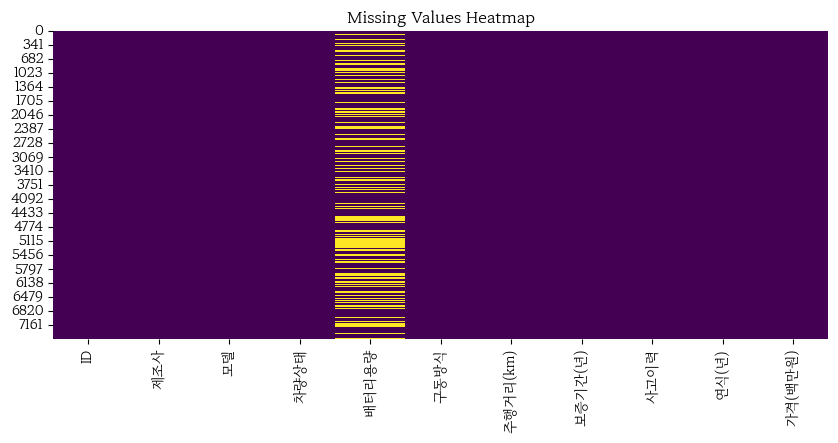

In [9]:
print("===== 결측치 개수 ==================================================")
print(train.isnull().sum())

print("")
# 시각적으로 결측치 확인 (heatmap)
print("===== 결측치 heatmap ==================================================")
plt.figure(figsize=(10,4))
sns.heatmap(train.isnull(), cbar=False, cmap="viridis")
plt.title("Missing Values Heatmap")
plt.show()

배터리용량 열에 결측치가 2711건(약 36%) 존재, 다른 컬럼은 결측치가 없는 반면, 배터리용량에만 집중되어 있음. <br/>
전기차 가격 예측에 있어 배터리용량은 중요한 변수 중 하나이므로, 결측치 처리 전략이 필요함.
* (1) 해당 결측행 제거: 데이터 손실이 많아질 수 있음.
* (2) 제조사·모델별 평균/중앙값 대체: 각 제조사·모델의 대표값으로 보완.
* (3) 다른 특성을 이용한 예측 모델(회귀/머신러닝)로 배터리용량 추정 후 대체.

## 수치형 컬럼 분석

===== 수치형 컬럼 히스토그램 & KDE =======================================================


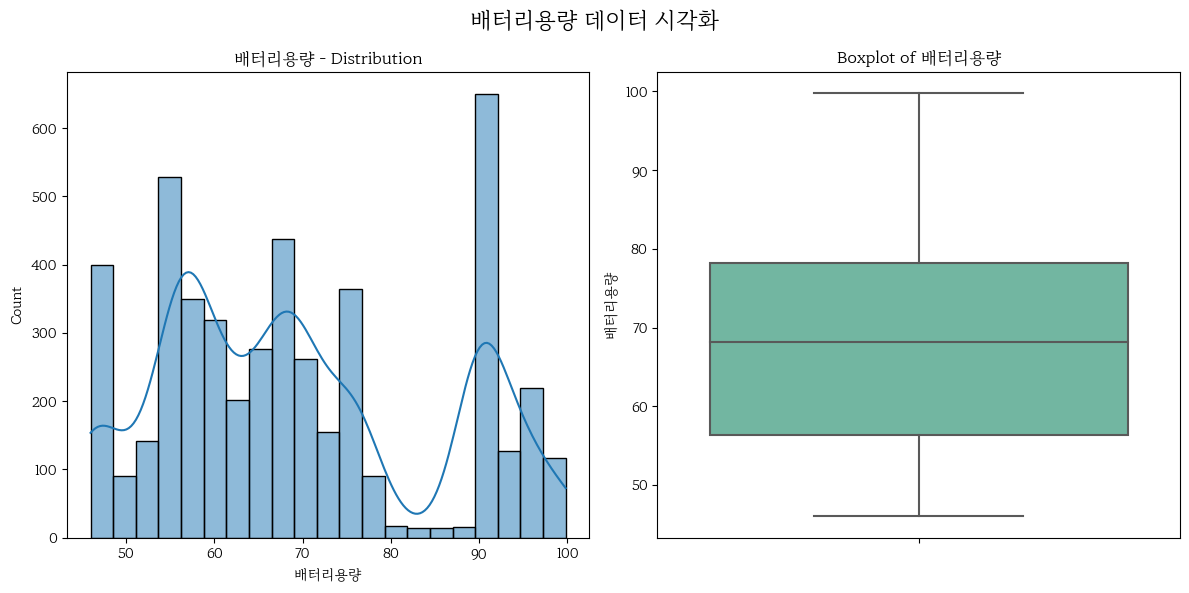

In [12]:
print("===== 수치형 컬럼 히스토그램 & KDE =======================================================")

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
# 히스토그램 & KDE
sns.histplot(train['배터리용량'], kde=True, ax=axes[0])
axes[0].set_title('배터리용량 - Distribution')

# 박스플롯
sns.boxplot(y=train['배터리용량'], palette="Set2", ax=axes[1])
axes[1].set_title('Boxplot of 배터리용량')

# 전체 제목 및 간격 조정
plt.suptitle("배터리용량 데이터 시각화", fontsize=16)
plt.tight_layout()
plt.show()

* 범위: 대략 46 ~ 99.8(kWh)
* 평균 69.4, 중앙값 68.1 정도로 전반적으로 60~80 선에 많이 분포.
* 박스플롯상 극단적인 값(45 이하, 100 근접)도 일부 존재.


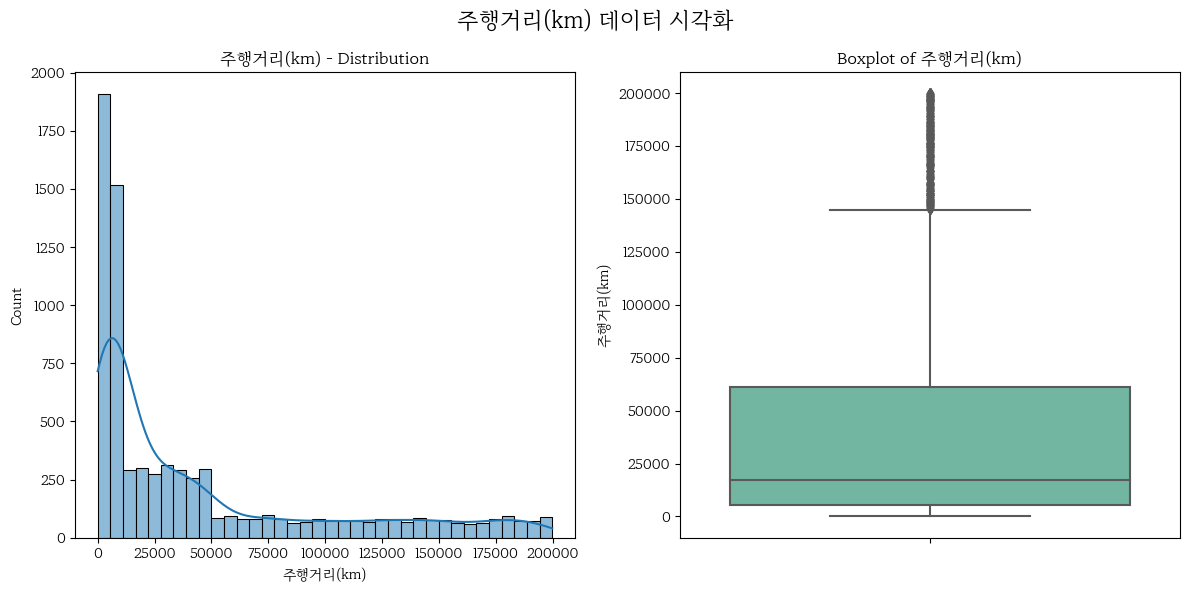

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
# 히스토그램 & KDE
sns.histplot(train['주행거리(km)'], kde=True, ax=axes[0])
axes[0].set_title('주행거리(km) - Distribution')

# 박스플롯
sns.boxplot(y=train['주행거리(km)'], palette="Set2", ax=axes[1])
axes[1].set_title('Boxplot of 주행거리(km)')

# 전체 제목 및 간격 조정
plt.suptitle("주행거리(km) 데이터 시각화", fontsize=16)
plt.tight_layout()
plt.show()

* 범위: 3km ~ 약 20만 km
* 전체적으로 오른쪽 꼬리가 긴 분포(편향)이며, 평균(약 4.4만 km)보다 중앙값(약 1.7만 km)이 훨씬 작음.
* 박스플롯에서도 상당한 이상치(outlier) 존재.

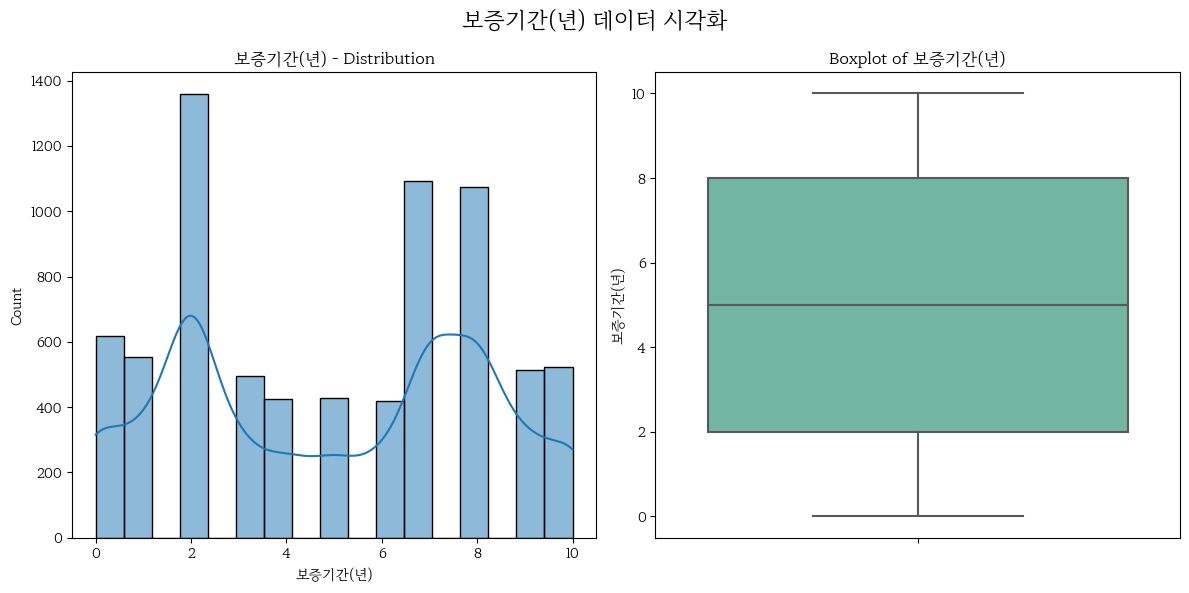

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
# 히스토그램 & KDE
sns.histplot(train['보증기간(년)'], kde=True, ax=axes[0])
axes[0].set_title('보증기간(년) - Distribution')

# 박스플롯
sns.boxplot(y=train['보증기간(년)'], palette="Set2", ax=axes[1])
axes[1].set_title('Boxplot of 보증기간(년)')

# 전체 제목 및 간격 조정
plt.suptitle("보증기간(년) 데이터 시각화", fontsize=16)
plt.tight_layout()
plt.show()

* 범위: 0 ~ 10년
* 2년, 7년, 8년 정도에 몰려있는 모습.

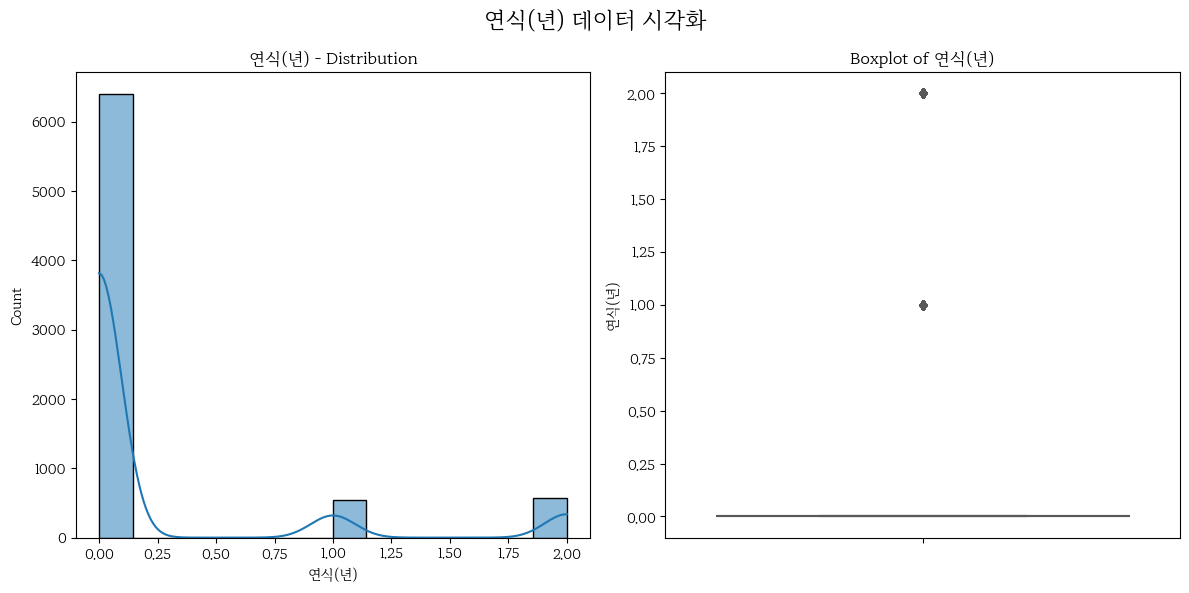

In [23]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
# 히스토그램 & KDE
sns.histplot(train['연식(년)'], kde=True, ax=axes[0])
axes[0].set_title('연식(년) - Distribution')

# 박스플롯
sns.boxplot(y=train['연식(년)'], palette="Set2", ax=axes[1])
axes[1].set_title('Boxplot of 연식(년)')

# 전체 제목 및 간격 조정
plt.suptitle("연식(년) 데이터 시각화", fontsize=16)
plt.tight_layout()
plt.show()

* 범위: 0년(=등록 후 1년 미만) ~ 2년
* 대부분의 차량이 1년 미만(0.xxx년) 혹은 1년 또는 2년인 것으로 보임.

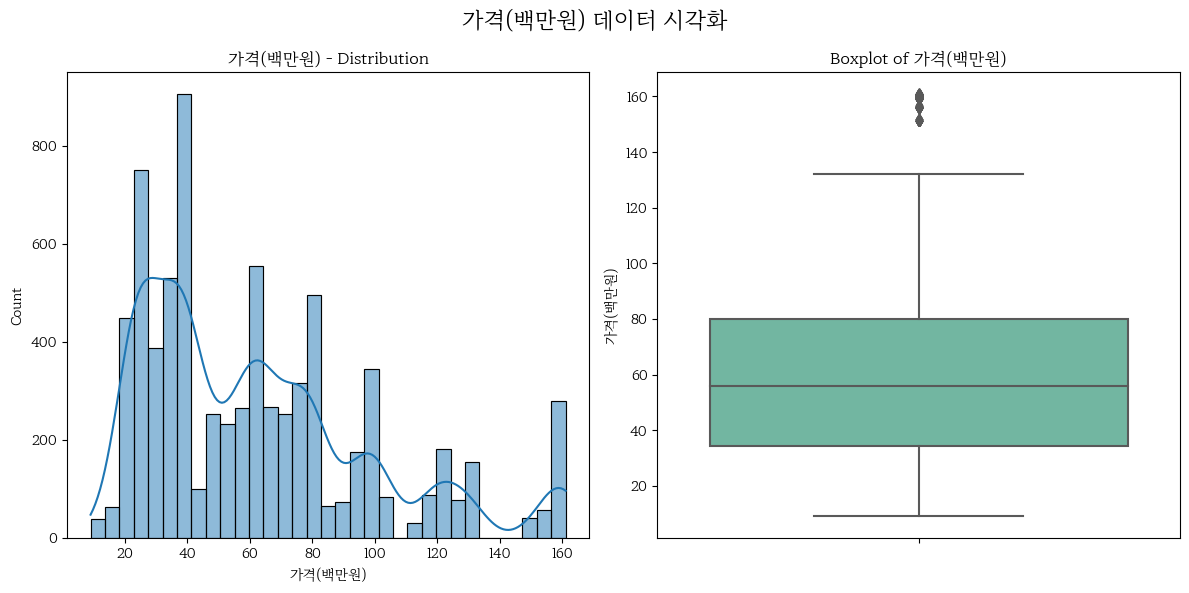

In [26]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
# 히스토그램 & KDE
sns.histplot(train['가격(백만원)'], kde=True, ax=axes[0])
axes[0].set_title('가격(백만원) - Distribution')

# 박스플롯
sns.boxplot(y=train['가격(백만원)'], palette="Set2", ax=axes[1])
axes[1].set_title('Boxplot of 가격(백만원)')

# 전체 제목 및 간격 조정
plt.suptitle("가격(백만원) 데이터 시각화", fontsize=16)
plt.tight_layout()
plt.show()

* 범위: 9백만원 ~ 161백만원
* 분포가 완만히 오른쪽으로 꼬리가 있음.
* 40 ~ 60백만원 구간에 많고, 박스플롯에서도 120 ~ 160백만원대가 상위 아웃라이어로 나타남.

**인사이트**

주행거리나 연식이 작은 차량일수록 가격이 높고, 배터리용량이 클수록 가격이 높을 것으로 추정. <br>
박스플롯에서 극단치(Outlier)가 많이 존재하기 때문에,<br>
(1) 로그 변환 등으로 분포 왜곡을 완화하거나,<br>
(2) 극단치 제거/클리핑 등을 고려해볼 수 있음.<br>
보증기간 또한 차량 상태와 더불어 가치 상승 요인이 될 가능성이 큼.

## 범주형 컬럼 분석

===== 범주형 컬럼 분포(Countplot) =======================================================


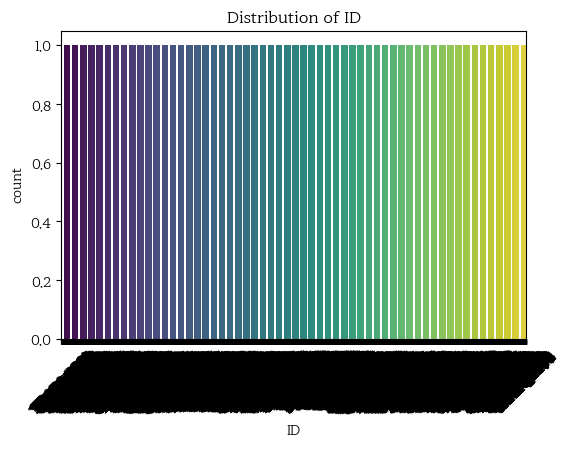

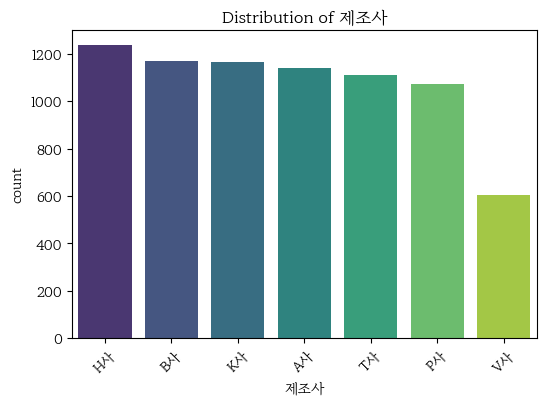

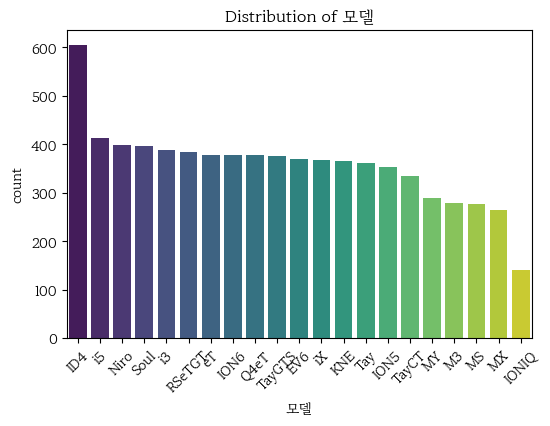

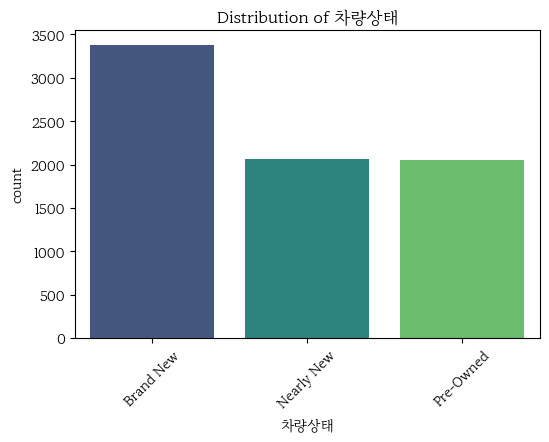

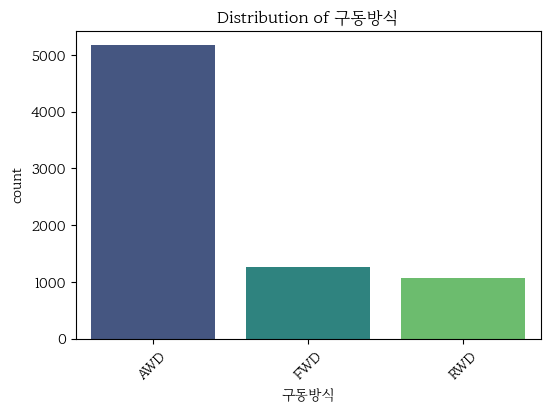

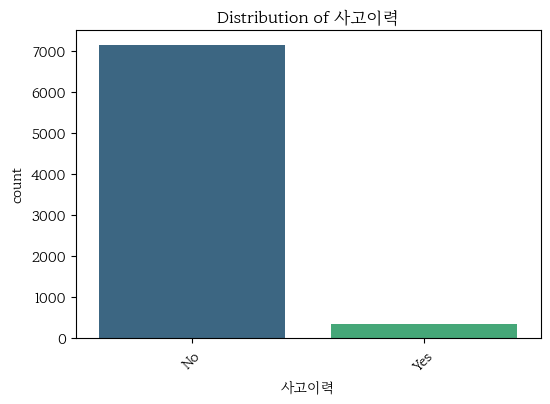

In [31]:
cat_cols = train.select_dtypes(include=['object']).columns

print("===== 범주형 컬럼 분포(Countplot) =======================================================")
for col in cat_cols:
    plt.figure(figsize=(6, 4))
    sns.countplot(x=train[col], order=train[col].value_counts().index, palette="viridis")
    plt.title(f'Distribution of {col}')
    plt.xticks(rotation=45)
    plt.show()

**제조사(7개)** : H사, B사, K사, A사, T사, P사, V사  <br>
H사가 가장 많고(V사 최소), 대략적으로 각 제조사마다 샘플 크기가 꽤 고르게 분포하지만 H사가 두드러짐. <br>
모델(21개)<br>
특정 모델(예: ID4)이 가장 많은 빈도를 차지, 그 뒤로 여러 모델이 비교적 고르게 분포.
제조사와 모델 간에는 1:N 관계가 있을 것이므로, 예측 시 ‘제조사 + 모델’ 정보를 묶어서 사용하는 방안 고려.<br>


**차량상태(3개)**: Brand New, Nearly New, Pre-Owned <br>
Brand New 비중이 가장 큼. Nearly New, Pre-Owned도 비슷한 수준으로 분포. <br>
주행거리와도 높은 연관 있을 것으로 추정 (Brand New는 주행거리가 매우 짧거나 0에 가까울 가능성 높음).<br>

**구동방식(3개)**: AWD > FWD > RWD 순으로 많음 <br>
전기차 특성상 4WD(AWD) 차량이 많은 편으로 보임.

**사고이력(2개)**: No > Yes <br>
압도적으로 사고이력이 없는 차량이 많음.

***인사이트*** <br>
차량 상태, 제조사/모델, 사고이력 등 범주형 변수 역시 가격에 영향을 줄 것으로 예상됨.<br>
범주형 변수를 원-핫 인코딩(one-hot encoding) 등의 방법으로 처리하고, 일부 중요한 범주는 레이블 인코딩(label encoding) 하여 모델에 반영할 수 있음.

## 상관관계

In [34]:
num_cols = train.select_dtypes(include=[np.number]).columns

C:\Users\jisu0\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


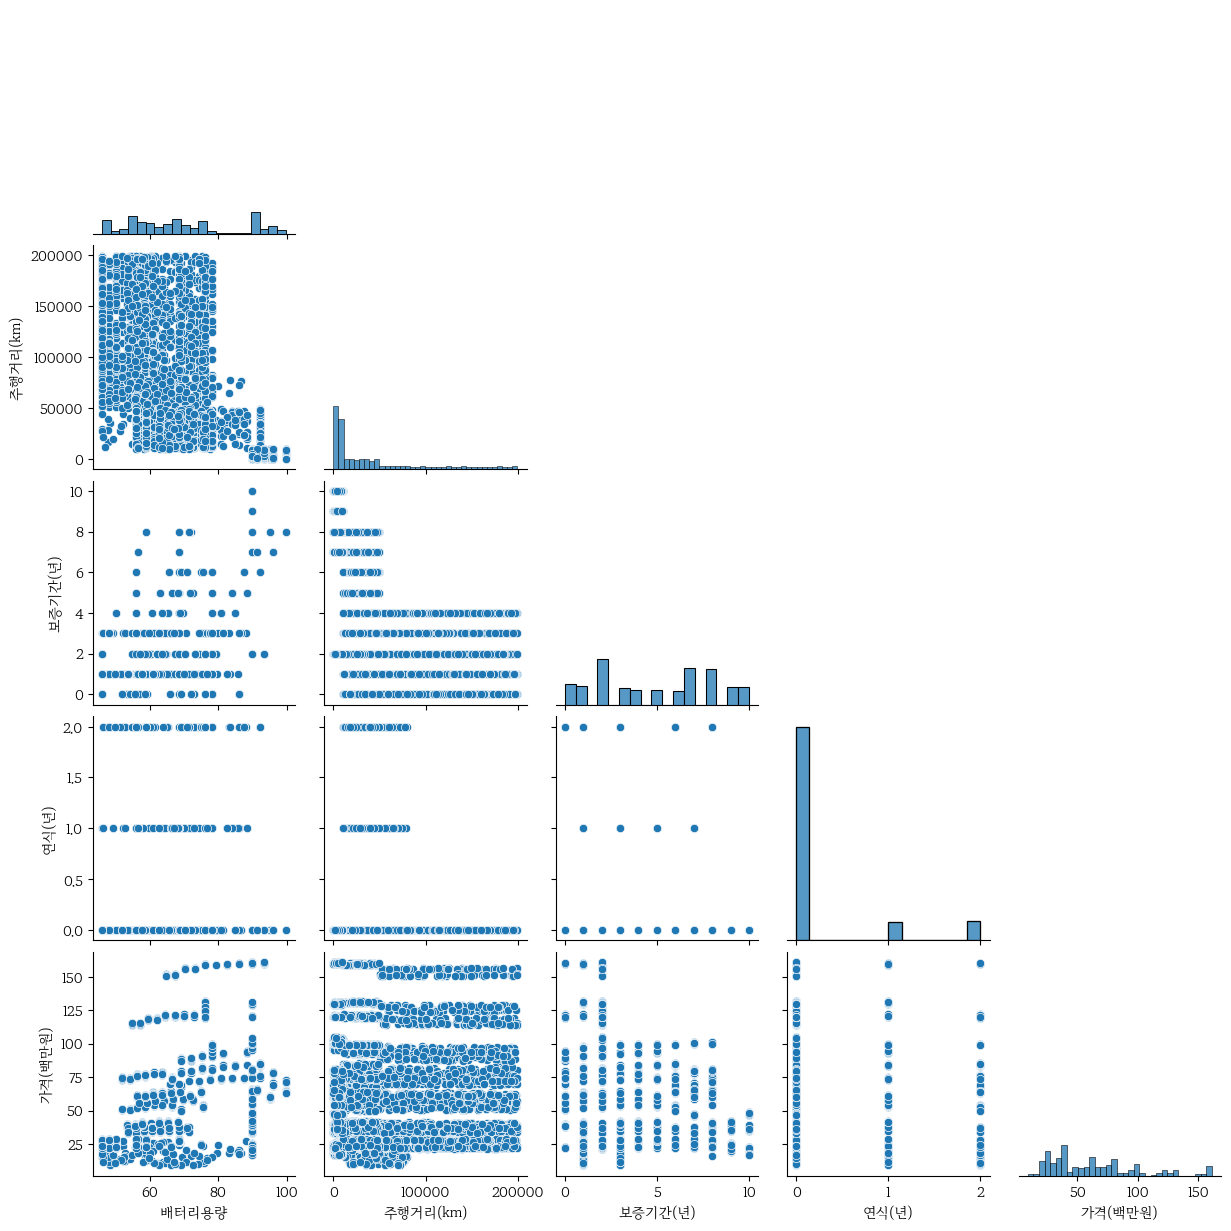

In [35]:
sns.pairplot(train[num_cols], corner=True)
plt.show()

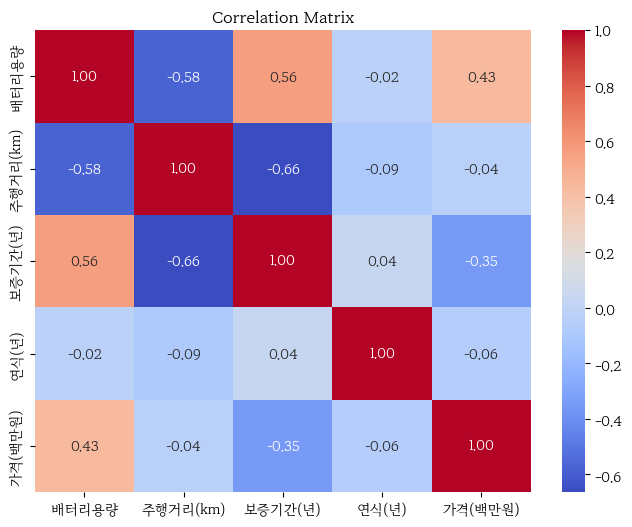

In [36]:
# 수치형 변수만 상관계수 계산
corr_matrix = train[num_cols].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()


1) 배터리용량 ↔ 보증기간(년): <br>
약 0.56 정도로 비교적 높은 양의 상관관계가 확인됩니다. <br>
배터리용량이 큰 차량일수록 제조사/판매자가 보증을 길게 제공하는 경향이 있을 것으로 추정됩니다. <br>

2) 배터리용량 ↔ 주행거리(km): <br>
약 -0.58로 음의 상관관계가 꽤 크게 나타납니다. <br>
배터리용량이 큰 차일수록 주행거리가 작다는 것은, 높은 용량 배터리를 가진 차량들이 비교적 신차(또는 주행거리 적은 차량)인 경우가 많다는 의미일 수 있습니다. <br>
반대로, 오래된 전기차는 배터리용량이 상대적으로 작게 출시됐고 주행거리도 많아졌을 가능성도 있습니다. <br>

3) 배터리용량 ↔ 가격(백만원): <br>
약 0.43 정도로 양의 상관관계. <br>
당연히 배터리용량이 큰 차량일수록 가격이 높게 형성되는 경향을 다시 한 번 확인할 수 있습니다. <br>

4) 주행거리(km) ↔ 보증기간(년): <br>
약 -0.66으로 음의 상관관계가 상당히 높습니다. <br>
주행거리가 많으면 보증기간이 짧거나 이미 소진되었을 가능성이 있고, 주행거리가 적으면 보증기간이 남아있다는 해석이 가능합니다. <br>

5) 주행거리(km) ↔ 가격(백만원): <br>
-0.04 정도로 거의 관계가 미약하게 보이지만, 실제로는 이상치가 많고 강한 비선형성이 있을 가능성이 큽니다. <br>
Plot(산점도)나 다른 변수(연식, 배터리용량, 차량상태 등)와의 상호작용에 따라 영향이 다르게 나타날 수 있습니다. <br>

6) 보증기간(년) ↔ 가격(백만원): <br>
약 -0.35, 음의 상관관계가 조금 의외일 수 있습니다. <br>
차량의 ‘나이’(연식)와 보증기간이 동시에 작용하기 때문일 수 있습니다. <br>
예를 들어, (1) 신차나 고가 차량 중 보증기간이 짧은 경우, 또는 (2) 보증기간은 길지만 실제로는 중저가형인 경우 등 여러 시나리오가 섞여서 단순 상관관계가 -0.35로 나타날 수 있습니다. <br>


6) 연식(년) ↔ 가격(백만원): <br>
약 0.30으로, 어느 정도 양의 상관이 있습니다(연식이 젊을수록 가격이 높은 경향). <br>
신차(0~1년 미만) 구간이 상당히 많아 박스플롯에서 이상치처럼 보이지만, 실제로는 가격이 높은 구간일 가능성이 높습니다.

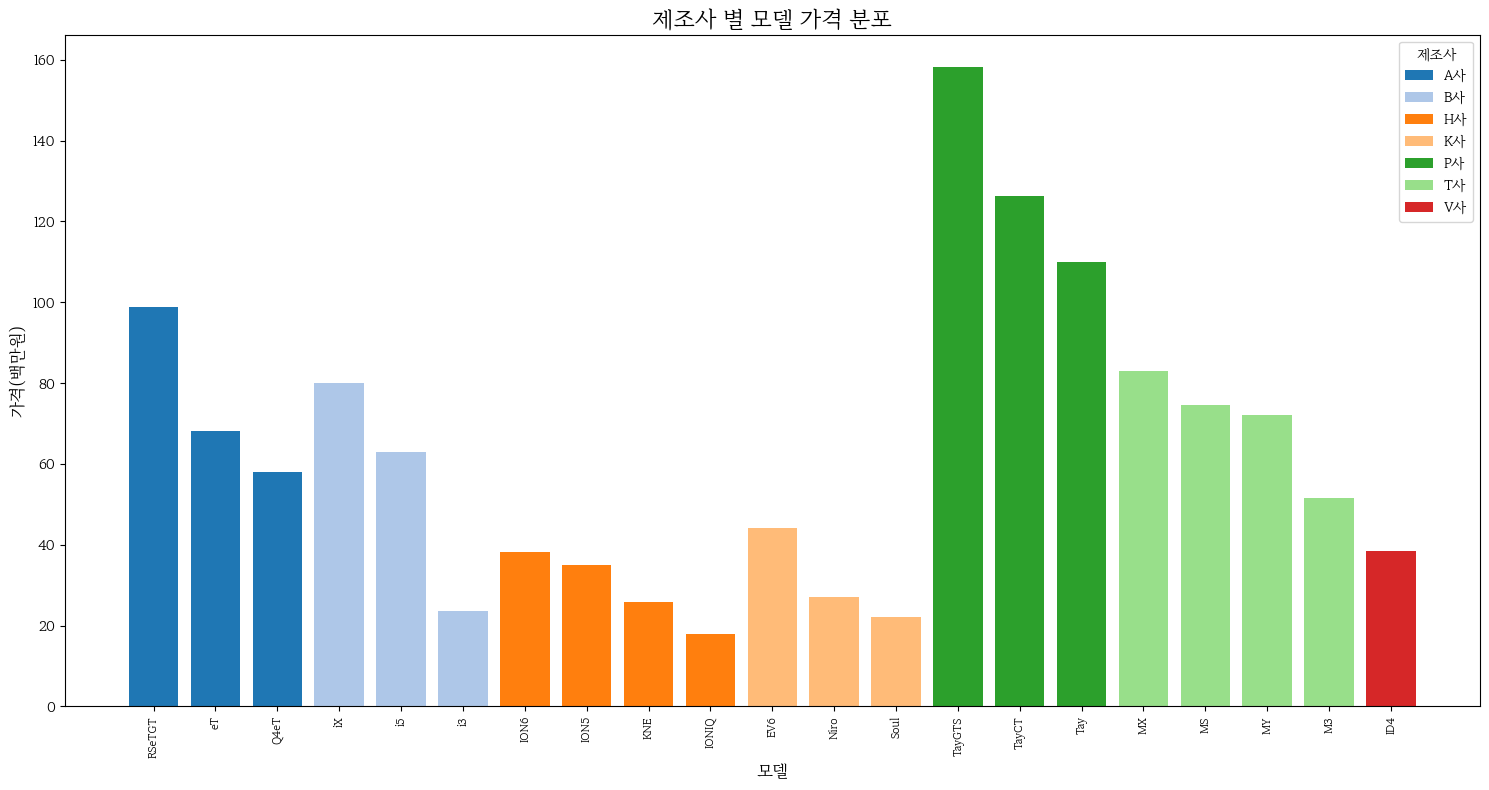

In [39]:
# 제조사의 모델별 가격의 평균으로 그룹화
grouped_data = train.groupby(['제조사', '모델'])['가격(백만원)'].mean().reset_index()

# 더 나은 그래프를 위해 제조사별로 정렬
grouped_data = grouped_data.sort_values(by=['제조사', '가격(백만원)'], ascending=[True, False])

# 그래프 크기 지정
plt.figure(figsize=(15, 8))

# 유니크한 제조사 명을 구하고, 색상 팔레트 지정
brands = grouped_data['제조사'].unique()
colors = plt.cm.tab20.colors[:len(brands)]

for i, brand in enumerate(brands):
    brand_data = grouped_data[grouped_data['제조사'] == brand]
    plt.bar(
        brand_data['모델'],
        brand_data['가격(백만원)'],
        label=brand,
        color=colors[i % len(colors)]
    )

plt.title('제조사 별 모델 가격 분포', fontsize=16)
plt.xlabel('모델', fontsize=12)
plt.ylabel('가격(백만원)', fontsize=12)
plt.xticks(rotation=90, fontsize=8)
plt.legend(title='제조사', fontsize=10, loc='upper right')
plt.tight_layout()
plt.show()

# 데이터 전처리

In [41]:
train_process = train.copy()

## 제조사 + 모델

train_process['name'] = train_process['제조사']+'_'+train_process['모델']
train_process = train_process.drop(columns=['제조사','모델'])

## 범주형 변수를 정수로 변환

In [46]:
# LabelEncoder를 사용하여 범주형 변수를 정수로 변환
label_cols = ['차량상태', '보증기간(년)','사고이력']
for col in label_cols:
    le = LabelEncoder()
    # 만약 '보증기간(년)'이 실제로는 숫자이지만 범주로 취급해야 한다면 str로 변환
    train_process[col] = le.fit_transform(train_process[col].astype(str))

In [48]:
# 2) One-Hot Encoding: '구동방식'
train_process = pd.get_dummies(train_process, columns=['구동방식'], prefix='method')
train_process = pd.get_dummies(train_process, columns=['제조사'], prefix='brand')

In [49]:
train_process['모델'].unique()

array(['TayGTS', 'Niro', 'eT', 'RSeTGT', 'i5', 'ION6', 'MS', 'MY', 'Q4eT',
       'ID4', 'TayCT', 'Soul', 'iX', 'MX', 'IONIQ', 'EV6', 'KNE', 'M3',
       'i3', 'ION5', 'Tay'], dtype=object)

In [51]:
# 주요 그룹 정의
def categorize_model(name):
    if name in ['TayGTS', 'RSeTGT', 'M3', 'Tay']:
        return 'Sports Car'
    elif name in ['i5', 'ION6', 'MS', 'TayCT']:
        return 'Electric Sedan'
    elif name in ['Niro', 'eT', 'MY', 'Q4eT', 'ID4', 'iX', 'MX', 'EV6', 'KNE']:
        return 'Electric SUV'
    elif name in ['IONIQ', 'Soul', 'ION5', 'i3']:
        return 'Electric Hatchback'
    else:
        return 'Other'

# 그룹 컬럼 추가
train_process['group'] = train_process['모델'].apply(categorize_model)

# 그룹별 원-핫 인코딩
train_process = pd.get_dummies(train_process, columns=['group'], prefix='group')

In [52]:
train_process.head()

,ID,모델,차량상태,배터리용량,주행거리(km),보증기간(년),사고이력,연식(년),가격(백만원),method_AWD,...,brand_B사,brand_H사,brand_K사,brand_P사,brand_T사,brand_V사,group_Electric Hatchback,group_Electric SUV,group_Electric Sedan,group_Sports Car
0,TRAIN_0000,TayGTS,1,86.077,13642,0,0,2,159.66,True,...,False,False,False,True,False,False,False,False,False,True
1,TRAIN_0001,Niro,1,56.000,10199,7,0,0,28.01,False,...,False,False,True,False,False,False,False,True,False,False
2,TRAIN_0002,eT,0,91.200,2361,8,0,0,66.27,True,...,False,False,False,False,False,False,False,True,False,False
3,TRAIN_0003,RSeTGT,1,NaN,21683,4,0,0,99.16,True,...,False,False,False,False,False,False,False,False,False,True
4,TRAIN_0004,i5,2,61.018,178205,1,0,0,62.02,True,...,True,False,False,False,False,False,False,False,True,False


In [53]:
train_process.columns

Index(['ID', '모델', '차량상태', '배터리용량', '주행거리(km)', '보증기간(년)', '사고이력', '연식(년)',
       '가격(백만원)', 'method_AWD', 'method_FWD', 'method_RWD', 'brand_A사',
       'brand_B사', 'brand_H사', 'brand_K사', 'brand_P사', 'brand_T사', 'brand_V사',
       'group_Electric Hatchback', 'group_Electric SUV',
       'group_Electric Sedan', 'group_Sports Car'],
      dtype='object')

## 결측치 처리

===== 전처리 전 =======================================================


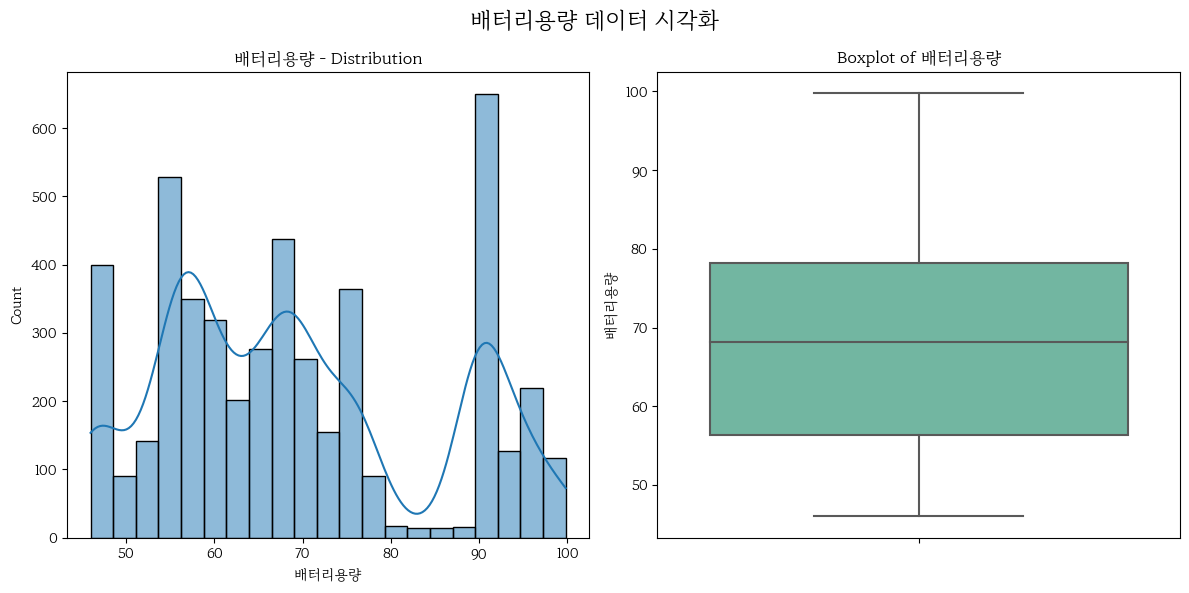

In [55]:
print("===== 전처리 전 =======================================================")

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
# 히스토그램 & KDE
sns.histplot(train['배터리용량'], kde=True, ax=axes[0])
axes[0].set_title('배터리용량 - Distribution')

# 박스플롯
sns.boxplot(y=train['배터리용량'], palette="Set2", ax=axes[1])
axes[1].set_title('Boxplot of 배터리용량')

# 전체 제목 및 간격 조정
plt.suptitle("배터리용량 데이터 시각화", fontsize=16)
plt.tight_layout()
plt.show()

### 회귀

In [54]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder

# 사용할 피처(컬럼) 정의
features = [
    '차량상태', '배터리용량', '주행거리(km)', '보증기간(년)', '사고이력', '연식(년)',
       '가격(백만원)', 'method_AWD', 'method_FWD', 'method_RWD', 'brand_A사',
       'brand_B사', 'brand_H사', 'brand_K사', 'brand_P사', 'brand_T사', 'brand_V사',
       'group_Electric Hatchback', 'group_Electric SUV',
       'group_Electric Sedan', 'group_Sports Car', 'group_Electric Hatchback',
       'group_Electric SUV', 'group_Electric Sedan', 'group_Sports Car'
]

# 결측치가 있는 행 / 없는 행 분리
df_not_missing = train_process[train_process['배터리용량'].notna()].copy()
df_missing = train_process[train_process['배터리용량'].isna()].copy()

# ------------------------------
# 2) 회귀 모델 훈련
# ------------------------------
X_train = df_not_missing[features]
y_train = df_not_missing['배터리용량']

# 예시로 RandomForest 사용 (파라미터는 필요에 맞게 조정)
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# ------------------------------
# 3) 결측치 데이터 예측 후 대체
# ------------------------------
X_test = df_missing[features]
y_pred = model.predict(X_test)

df_missing['배터리용량'] = y_pred  # 예측값으로 결측치 대체

# ------------------------------
# 4) 최종 데이터프레임 결합
# ------------------------------
train_process_filled = pd.concat([df_not_missing, df_missing], axis=0)
# 인덱스 순서가 섞일 수 있으므로, 필요하면 다시 정렬
train_process_filled.sort_index(inplace=True)

===== 전처리 후 =======================================================


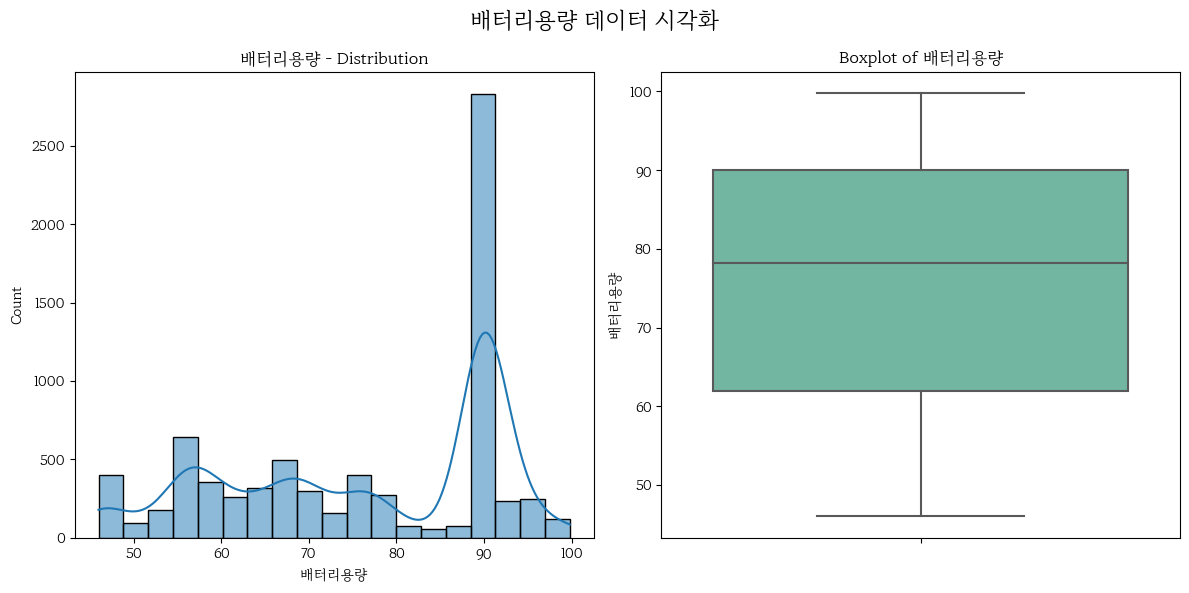

In [56]:
print("===== 전처리 후 =======================================================")

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
# 히스토그램 & KDE
sns.histplot(train_process_filled['배터리용량'], kde=True, ax=axes[0])
axes[0].set_title('배터리용량 - Distribution')

# 박스플롯
sns.boxplot(y=train_process_filled['배터리용량'], palette="Set2", ax=axes[1])
axes[1].set_title('Boxplot of 배터리용량')

# 전체 제목 및 간격 조정
plt.suptitle("배터리용량 데이터 시각화", fontsize=16)
plt.tight_layout()
plt.show()

### 회귀 모델 앙상블

In [76]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LassoCV

# 피처 정의
features = [
   '차량상태', '주행거리(km)', '보증기간(년)', '사고이력', '연식(년)',
   '가격(백만원)', 'method_AWD', 'method_FWD', 'method_RWD', 'brand_A사',
   'brand_B사', 'brand_H사', 'brand_K사', 'brand_P사', 'brand_T사', 'brand_V사',
   'group_Electric Hatchback', 'group_Electric SUV',
   'group_Electric Sedan', 'group_Sports Car'
]

# 데이터 분리
df_not_missing = train_process[train_process['배터리용량'].notna()].copy()
df_missing = train_process[train_process['배터리용량'].isna()].copy()

# 전처리
X_train = df_not_missing[features]
y_train = df_not_missing['배터리용량']
X_test = df_missing[features]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 모델 정의
base_models = {
   'rf': RandomForestRegressor(random_state=42),
   'gb': GradientBoostingRegressor(random_state=42),
   'lasso': LassoCV(random_state=42)
}

# 하이퍼파라미터 
params = {
   'rf': {
       'n_estimators': [100, 200, 300],
       'max_depth': [10, 20, 30, None],
       'min_samples_split': [2, 5, 10]
   },
   'gb': {
       'n_estimators': [100, 200],
       'learning_rate': [0.01, 0.1],
       'max_depth': [3, 5, 7]
   }
}

# 모델 학습 및 예측
predictions = {}
for name, model in base_models.items():
   if name in params:
       grid = GridSearchCV(model, params[name], cv=5, n_jobs=-1)
       grid.fit(X_train_scaled, y_train)
       predictions[name] = grid.predict(X_test_scaled)
       print(f"{name} Best params:", grid.best_params_)
   else:
       model.fit(X_train_scaled, y_train)
       predictions[name] = model.predict(X_test_scaled)
   
   # 교차검증 점수
   cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5)
   print(f"{name} CV scores:", cv_scores.mean(), "±", cv_scores.std())

# 앙상블 예측
final_pred = np.mean(list(predictions.values()), axis=0)

# 결과 병합
df_missing['배터리용량'] = final_pred
train_process_filled_2 = pd.concat([df_not_missing, df_missing], axis=0)
train_process_filled_2.sort_index(inplace=True)

rf Best params: {'max_depth': 20, 'min_samples_split': 10, 'n_estimators': 200}
rf CV scores: 0.9834212843599841 ± 0.005886369745558841
gb Best params: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 100}
gb CV scores: 0.9722756163089106 ± 0.005468563705671422
lasso CV scores: 0.8661932127604979 ± 0.0073776124378512956


* 모델 앙상블
   * RandomForest: 트리 기반 앙상블 학습
   * GradientBoosting: 부스팅 기반 앙상블 학습
   * Lasso: 규제가 있는 선형 모델

* 하이퍼파라미터 최적화
   * GridSearchCV로 각 모델의 최적 파라미터 탐색
   * 5-fold 교차검증으로 과적합 방지

* 최종 예측
    * 각 모델의 예측값 평균으로 최종 예측

===== 전처리 후 =======================================================


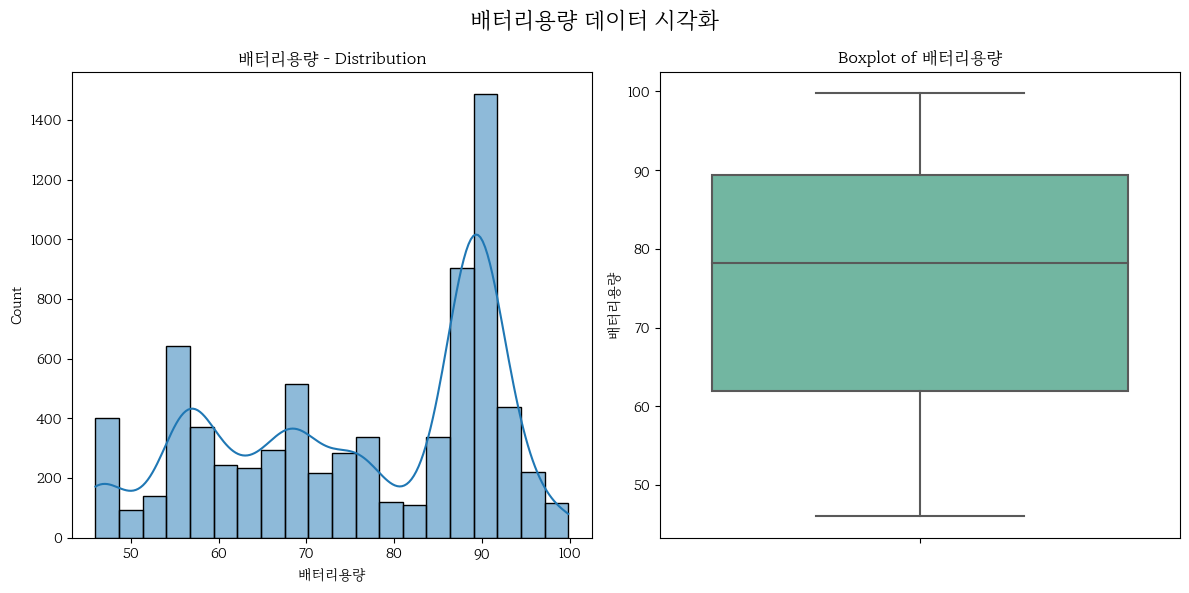

In [77]:
print("===== 전처리 후 =======================================================")

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
# 히스토그램 & KDE
sns.histplot(train_process_filled_2['배터리용량'], kde=True, ax=axes[0])
axes[0].set_title('배터리용량 - Distribution')

# 박스플롯
sns.boxplot(y=train_process_filled_2['배터리용량'], palette="Set2", ax=axes[1])
axes[1].set_title('Boxplot of 배터리용량')

# 전체 제목 및 간격 조정
plt.suptitle("배터리용량 데이터 시각화", fontsize=16)
plt.tight_layout()
plt.show()

In [83]:
train_process_filled_2 = train_process_filled_2.drop(columns=['모델'])

### TEST 데이터 전처리, 결측치 리리

In [134]:
test_backup = test.copy()

In [188]:
label_cols = ['차량상태', '보증기간(년)','사고이력']
for col in label_cols:
    le = LabelEncoder()
    # 만약 '보증기간(년)'이 실제로는 숫자이지만 범주로 취급해야 한다면 str로 변환
    test[col] = le.fit_transform(test[col].astype(str))

# 2) One-Hot Encoding: '구동방식'
test = pd.get_dummies(test, columns=['구동방식'], prefix='method')
test = pd.get_dummies(test, columns=['제조사'], prefix='brand')

# 주요 그룹 정의
def categorize_model(name):
    if name in ['TayGTS', 'RSeTGT', 'M3', 'Tay']:
        return 'Sports Car'
    elif name in ['i5', 'ION6', 'MS', 'TayCT']:
        return 'Electric Sedan'
    elif name in ['Niro', 'eT', 'MY', 'Q4eT', 'ID4', 'iX', 'MX', 'EV6', 'KNE']:
        return 'Electric SUV'
    elif name in ['IONIQ', 'Soul', 'ION5', 'i3']:
        return 'Electric Hatchback'
    else:
        return 'Other'

# 그룹 컬럼 추가
test['group'] = test['모델'].apply(categorize_model)

# 그룹별 원-핫 인코딩
test = pd.get_dummies(test, columns=['group'], prefix='group')

# =======================================================================================================
# 피처 정의
features = [
   '차량상태', '주행거리(km)', '보증기간(년)', '사고이력', '연식(년)',
   'method_AWD', 'method_FWD', 'method_RWD', 'brand_A사',
   'brand_B사', 'brand_H사', 'brand_K사', 'brand_P사', 'brand_T사', 'brand_V사',
   'group_Electric Hatchback', 'group_Electric SUV',
   'group_Electric Sedan', 'group_Sports Car'
]

# 데이터 분리
df_not_missing = test[test['배터리용량'].notna()].copy()
df_missing = test[test['배터리용량'].isna()].copy()

# 전처리
X_train = df_not_missing[features]
y_train = df_not_missing['배터리용량']
X_test = df_missing[features]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 모델 정의
base_models = {
   'rf': RandomForestRegressor(random_state=42),
   'gb': GradientBoostingRegressor(random_state=42),
   'lasso': LassoCV(random_state=42)
}

# 하이퍼파라미터 
params = {
   'rf': {
       'n_estimators': [100, 200, 300],
       'max_depth': [10, 20, 30, None],
       'min_samples_split': [2, 5, 10]
   },
   'gb': {
       'n_estimators': [100, 200],
       'learning_rate': [0.01, 0.1],
       'max_depth': [3, 5, 7]
   }
}

# 모델 학습 및 예측
predictions = {}
for name, model in base_models.items():
   if name in params:
       grid = GridSearchCV(model, params[name], cv=5, n_jobs=-1)
       grid.fit(X_train_scaled, y_train)
       predictions[name] = grid.predict(X_test_scaled)
       print(f"{name} Best params:", grid.best_params_)
   else:
       model.fit(X_train_scaled, y_train)
       predictions[name] = model.predict(X_test_scaled)
   
   # 교차검증 점수
   cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5)
   print(f"{name} CV scores:", cv_scores.mean(), "±", cv_scores.std())

# 앙상블 예측
final_pred = np.mean(list(predictions.values()), axis=0)

# 결과 병합
df_missing['배터리용량'] = final_pred
test_process_filled = pd.concat([df_not_missing, df_missing], axis=0)
test_process_filled.sort_index(inplace=True)
# =======================================================================================================

x_test = test_process_filled[price_features]

rf Best params: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 200}
rf CV scores: 0.9124628194406149 ± 0.016186784971637863
gb Best params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
gb CV scores: 0.9223488718654655 ± 0.017352679754940734
lasso CV scores: 0.8053478362176744 ± 0.041628482174310776


# 예측

In [198]:
# train_process_filled_2에서 가격 예측 모델 학습
price_features = [
   '차량상태', '배터리용량', '주행거리(km)', '보증기간(년)', '사고이력', '연식(년)',
   'method_AWD', 'method_FWD', 'method_RWD',
   'brand_A사', 'brand_B사', 'brand_H사', 'brand_K사', 'brand_P사', 'brand_T사', 'brand_V사',
   'group_Electric Hatchback', 'group_Electric SUV', 
   'group_Electric Sedan', 'group_Sports Car'
]

x_train = train_process_filled_2[price_features]
y_train = train_process_filled_2['가격(백만원)']

# 가격 예측 모델
model = DecisionTreeRegressor()
model.fit(x_train, y_train)

DecisionTreeRegressor()

===== 결측치 heatmap ==================================================


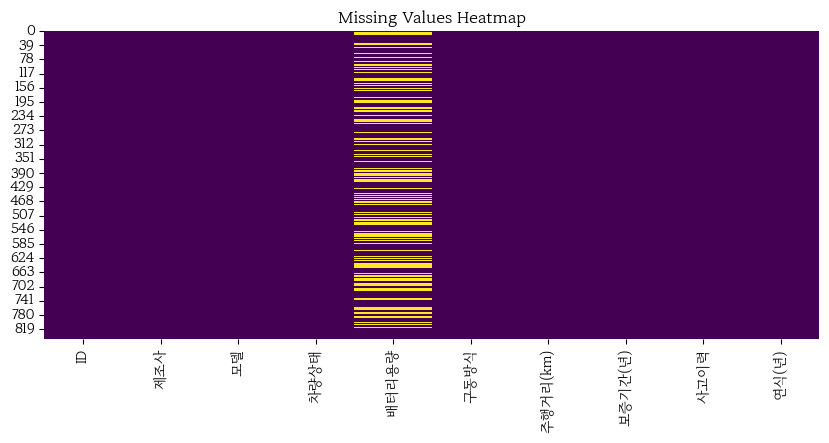

In [92]:
print("===== 결측치 heatmap ==================================================")
plt.figure(figsize=(10,4))
sns.heatmap(test.isnull(), cbar=False, cmap="viridis")
plt.title("Missing Values Heatmap")
plt.show()

In [200]:
# 예측을 수행합니다.
pred = model.predict(x_test)

In [202]:
# sample_submission 파일을 불러옵니다.
submit = pd.read_csv('./sample_submission.csv')

In [204]:
# 예측한 결과를 submit에 저장합니다.
submit['가격(백만원)'] = pred
submit.head()

,ID,가격(백만원)
0,TEST_000,130.84
1,TEST_001,80.26
2,TEST_002,65.94
3,TEST_003,34.21
4,TEST_004,22.58


In [206]:
# 제출을 위해 baseline_submission.csv란 이름으로 CSV 파일을 저장합니다.
submit.to_csv('./submission_2.csv',index=False)